In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from PIL import Image

import random
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchinfo import summary
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import accuracy, F1Score
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_size = 224
batch = 32

train_df = pd.read_csv('/kaggle/input/hackathon-online-cloud-recognition/train.csv')
train_df

,id,label
0,f164dae2e2cdd4e5411e93a8dc95d142.jpg,3
1,588083bc2555da85c1db7e8abd9d6922.jpg,1
2,dd20037db2aa28f7b617bbf5f6754470.jpg,2
3,a6d1c3b86279c54afd4e2fdf0b88111a.jpg,2
4,8989be70528a5ff4cfa6d098afb5722e.jpg,1
...,...,...
955,71887a10482a6a64043a210132a22a0d.jpg,5
956,08583d3ab0b1dfabce632b2d545b80e0.jpg,2
957,eba41f3ef7334728d94852e1f1eee5a9.jpg,3
958,fbcf3d1c87e12b5e0c81cb1bfdbf3afe.jpg,2


In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['id'], train_df['label'], 
                                                      test_size=0.2, 
                                                      random_state=42, 
                                                      stratify=train_df[['label']])

In [4]:
train_df['is_valid'] = train_df.index.isin(list(y_valid.index))
train_df

,id,label,is_valid
0,f164dae2e2cdd4e5411e93a8dc95d142.jpg,3,False
1,588083bc2555da85c1db7e8abd9d6922.jpg,1,False
2,dd20037db2aa28f7b617bbf5f6754470.jpg,2,False
3,a6d1c3b86279c54afd4e2fdf0b88111a.jpg,2,False
4,8989be70528a5ff4cfa6d098afb5722e.jpg,1,False
...,...,...,...
955,71887a10482a6a64043a210132a22a0d.jpg,5,True
956,08583d3ab0b1dfabce632b2d545b80e0.jpg,2,False
957,eba41f3ef7334728d94852e1f1eee5a9.jpg,3,False
958,fbcf3d1c87e12b5e0c81cb1bfdbf3afe.jpg,2,False


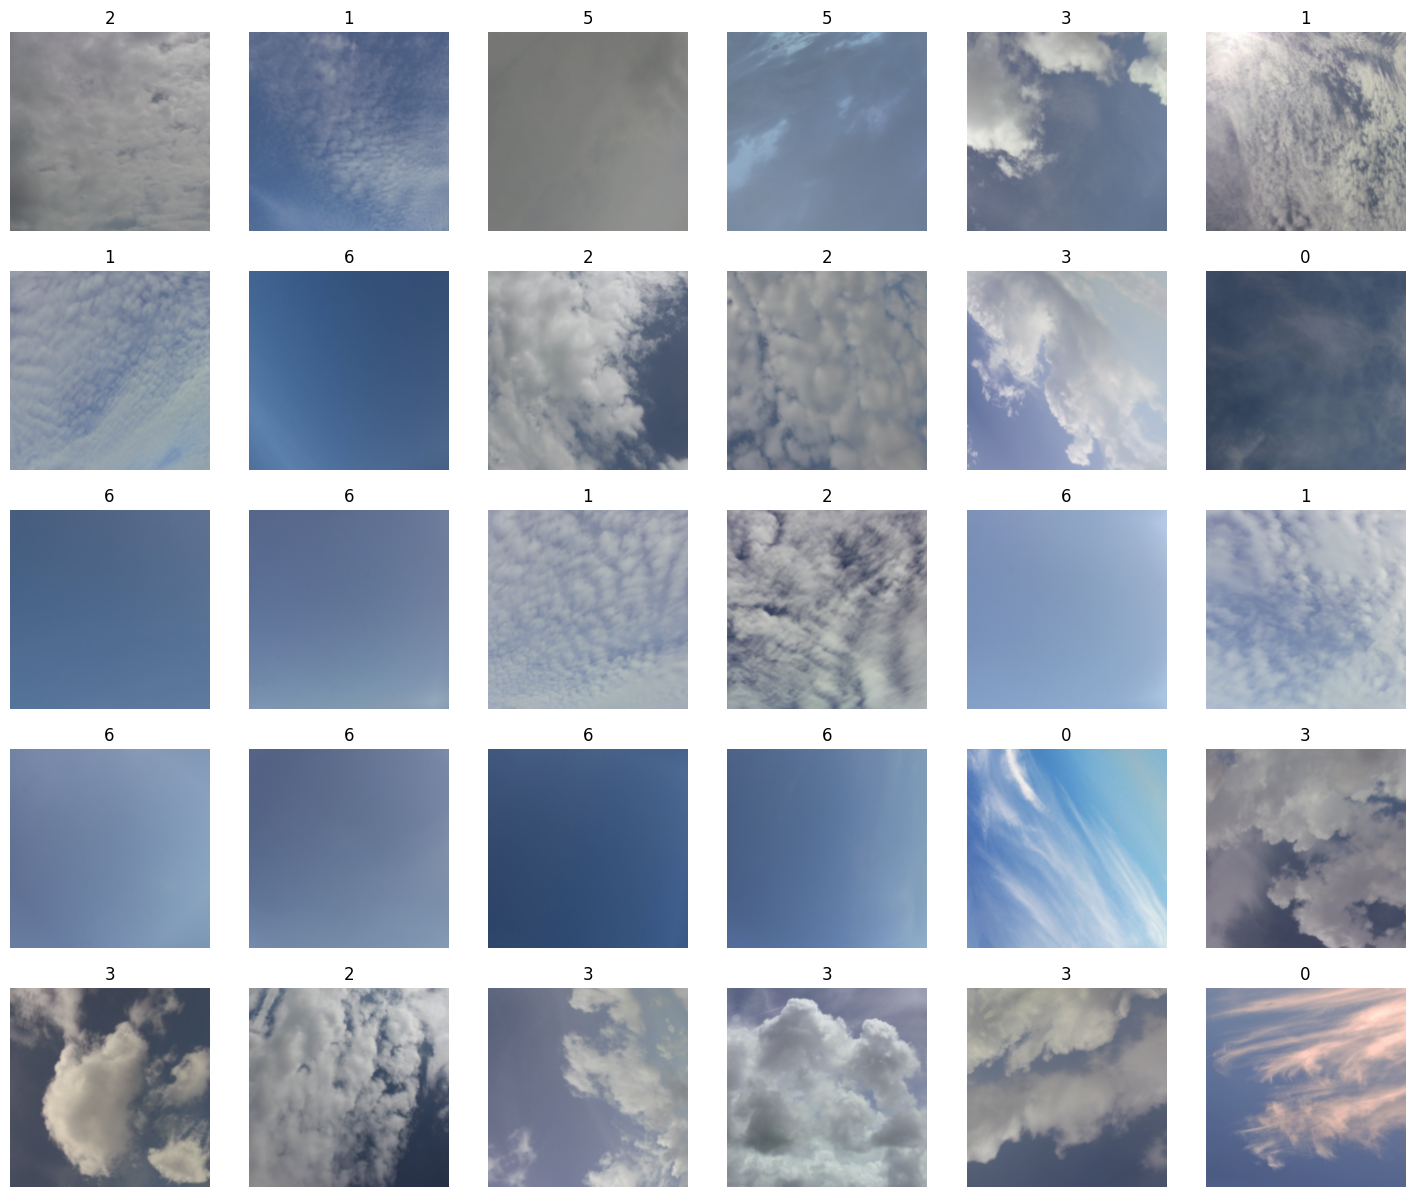

In [5]:
dls = ImageDataLoaders.from_df(train_df,
                                    path='/kaggle/input/hackathon-online-cloud-recognition/images/train',
                                    valid_col='is_valid',
                                    bs = batch ,
                                    item_tfms=[ToTensor(),Resize(image_size)] ,
                                    batch_tfms=[*aug_transforms(do_flip=False,
                                                                flip_vert=True,
                                                                max_rotate=360,
                                                                p_affine=0.8,
                                                                max_warp=0.2),
                                                Normalize.from_stats(*imagenet_stats),
                                               ],
                                    seed = 123,
                                    )

dls.train.show_batch(max_n=30)

In [6]:
timm.list_models('*resnet*',pretrained=True)

['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_i

In [7]:
# loss_func2 = CrossEntropyLossFlat(weight=class_weights)
save_cb = SaveModelCallback(monitor='valid_loss')

# Create a list of callbacks
callbacks = [save_cb] 
model_name = "resnet101.a1_in1k"

In [8]:
learn = vision_learner(dls, model_name,
                       path='/kaggle/working/resnet/',
                       cbs=[ShowGraphCallback()] ,
                       metrics=[accuracy])  # metrics=[accuracy]
                     #    #,WandbCallback()     force_download=True, 
learn.to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.659888,0.551462,0.791667,01:09


Better model found at epoch 0 with valid_loss value: 0.5514615178108215.


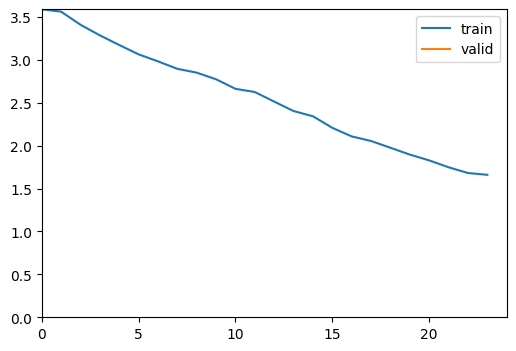

epoch,train_loss,valid_loss,accuracy,time
0,0.749945,0.448224,0.833333,01:05
1,0.720972,0.447764,0.859375,01:07
2,0.678585,0.510542,0.843750,01:08
3,0.634538,0.572104,0.848958,01:08
4,0.634614,0.410494,0.895833,01:10
5,0.557527,0.348044,0.906250,01:08
6,0.510006,0.325461,0.911458,01:07
7,0.503761,0.384547,0.895833,01:06
8,0.477888,0.379951,0.901042,01:08
9,0.437249,0.367415,0.895833,01:07


Better model found at epoch 0 with valid_loss value: 0.4482243061065674.


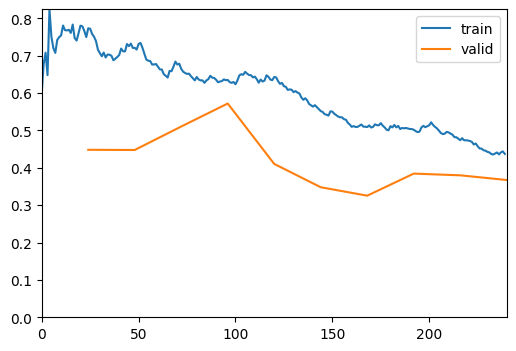

Better model found at epoch 1 with valid_loss value: 0.4477640688419342.
Better model found at epoch 4 with valid_loss value: 0.41049352288246155.
Better model found at epoch 5 with valid_loss value: 0.34804365038871765.
Better model found at epoch 6 with valid_loss value: 0.3254612684249878.


In [9]:
learn.fine_tune(10,cbs=callbacks)

In [10]:
gpu_memory_info = torch.cuda.memory_summary(device=None, abbreviated=False)
print(gpu_memory_info)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 732821 KiB |   2868 MiB |   3084 GiB |   3083 GiB |
|       from large pool | 521664 KiB |   2634 MiB |   3020 GiB |   3020 GiB |
|       from small pool | 211157 KiB |    258 MiB |     63 GiB |     63 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 732821 KiB |   2868 MiB |   3084 GiB |   3083 GiB |
|       from large pool | 521664 KiB |   2634 MiB |   3020 GiB |

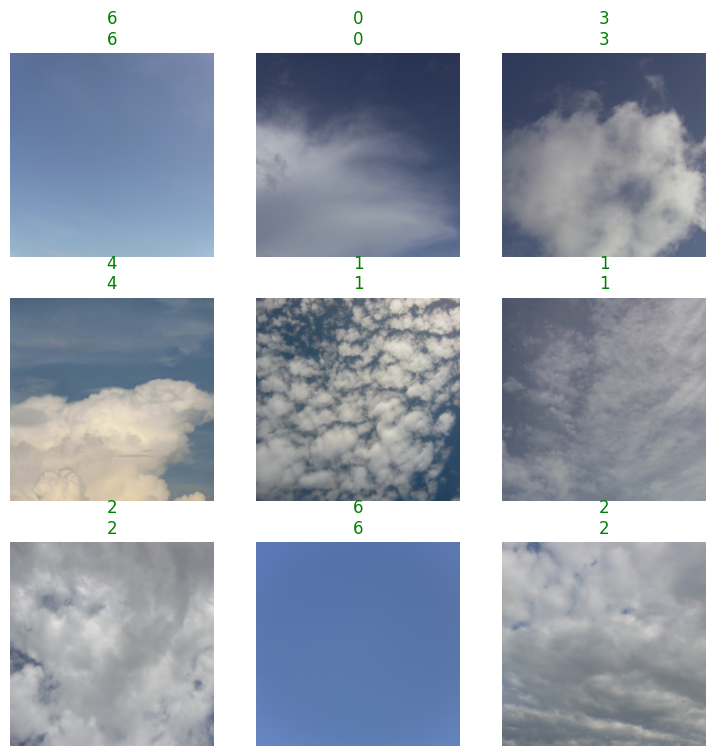

In [11]:
learn.export('/kaggle/working/resnet.pkl')
learn.validate()
learn.show_results()

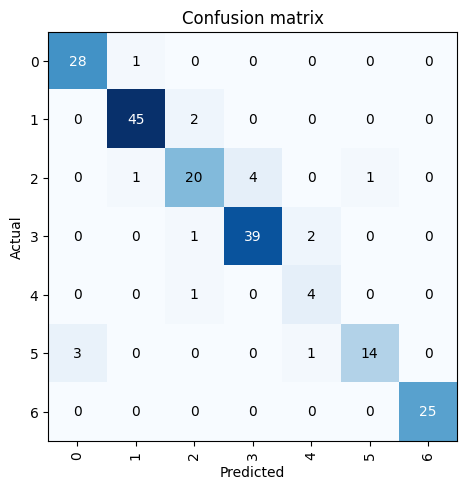

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.96      0.96      0.96        47
           2       0.83      0.77      0.80        26
           3       0.91      0.93      0.92        42
           4       0.57      0.80      0.67         5
           5       0.93      0.78      0.85        18
           6       1.00      1.00      1.00        25

    accuracy                           0.91       192
   macro avg       0.87      0.89      0.87       192
weighted avg       0.91      0.91      0.91       192



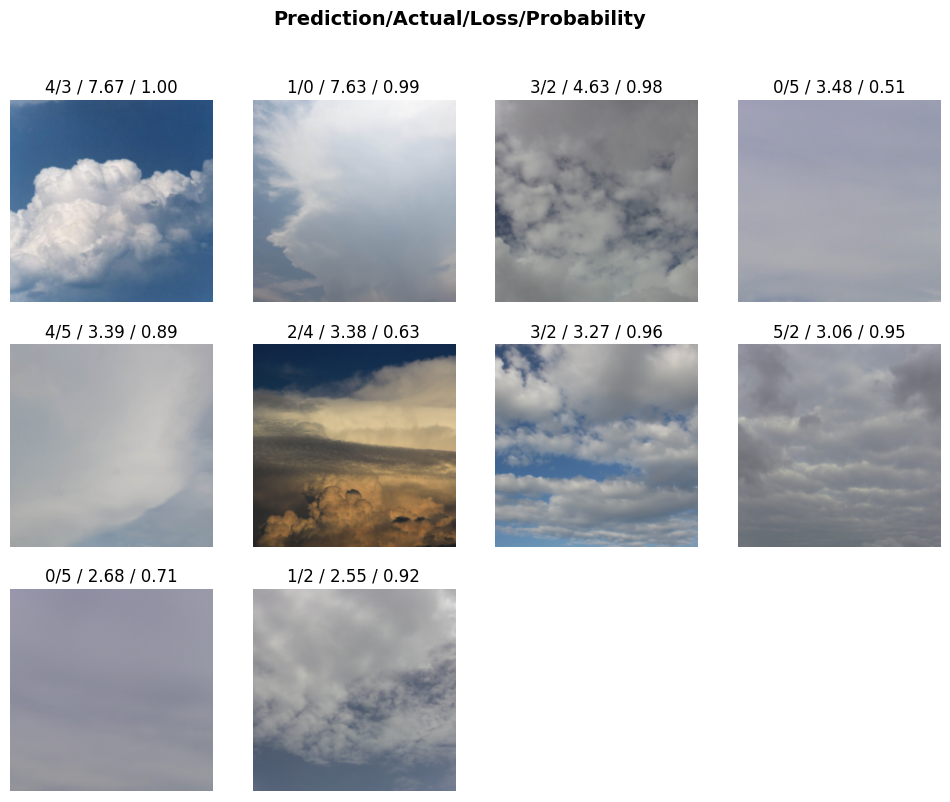

In [14]:
interp.plot_top_losses(10)